In [1]:
!pip install hypernetx matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.3/579.3 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


# **Unweighted Hypergraph Clustering on a Sample Dataset**

There are 6 connected components.

Processing component 1 with 4 nodes.
Clustering result for component 1:
{1: [72, 165, 517]}


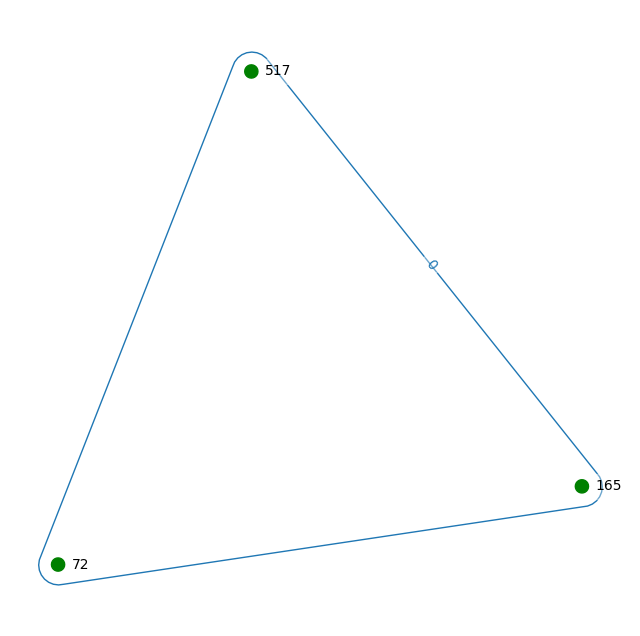


Processing component 2 with 5 nodes.
Clustering result for component 2:
{1: [875, 1024, 1742, 2059]}


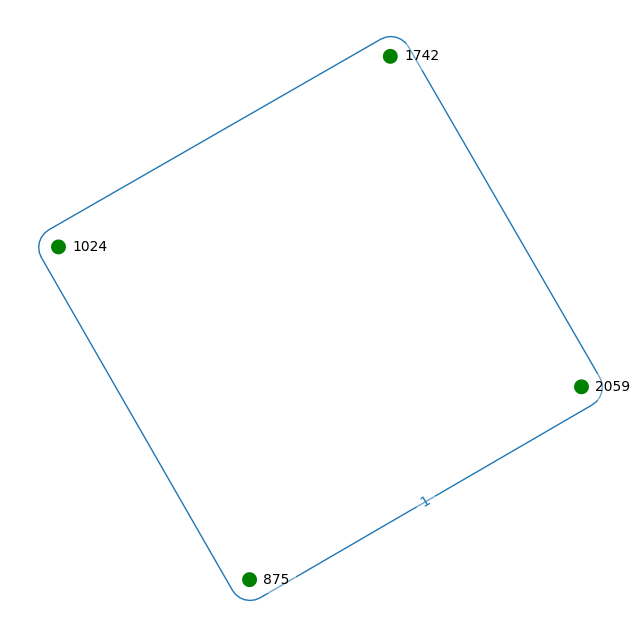


Processing component 3 with 4 nodes.
Clustering result for component 3:
{1: [2252, 2429, 3622]}


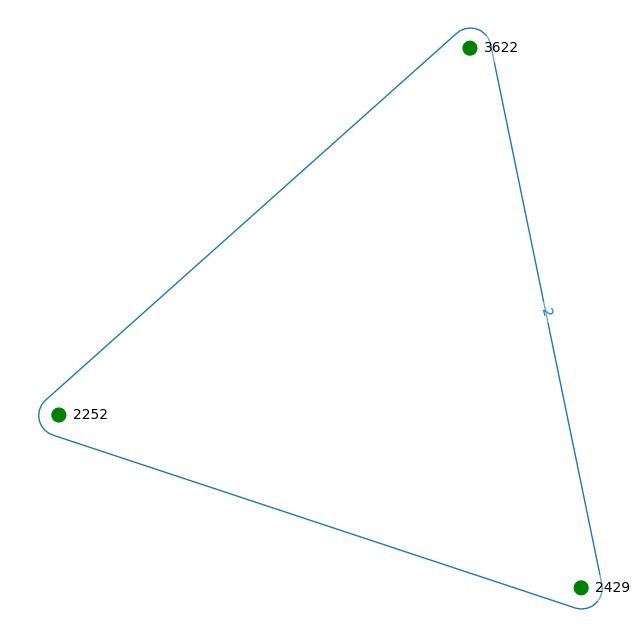


Processing component 4 with 5 nodes.
Clustering result for component 4:
{1: [5036, 5080, 5088, 5703]}


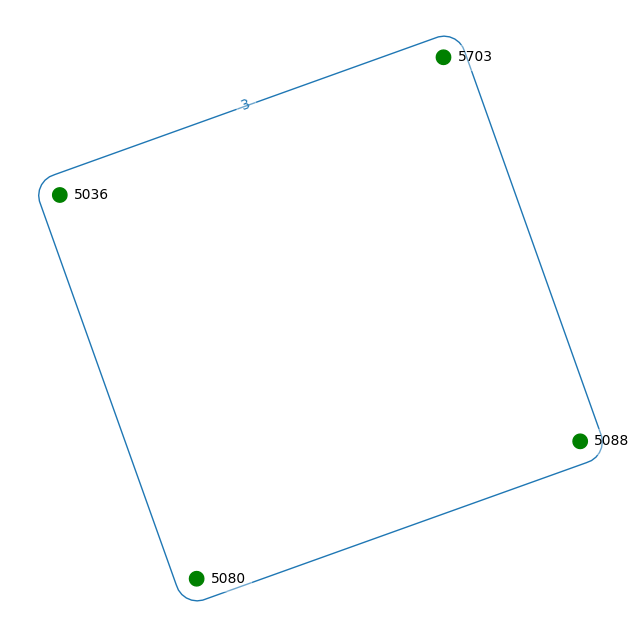


Processing component 5 with 4 nodes.
Clustering result for component 5:
{1: [5873, 6723, 6752]}


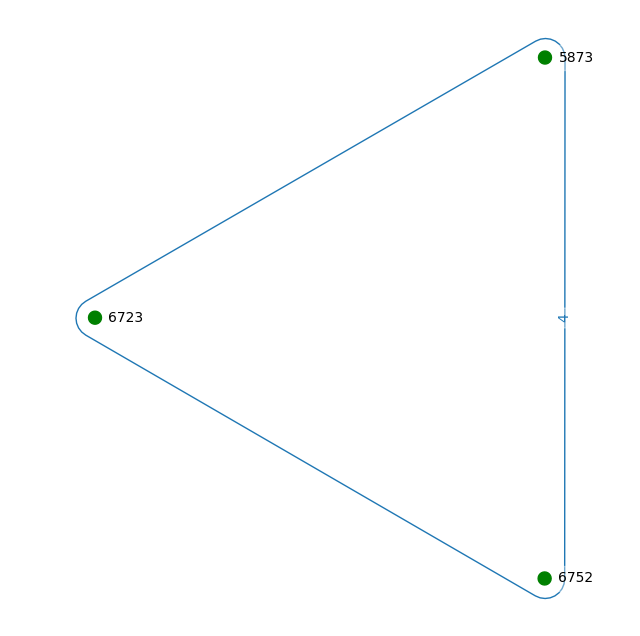


Processing component 6 with 5 nodes.
Clustering result for component 6:
{1: [8459, 8752, 8885, 9553]}


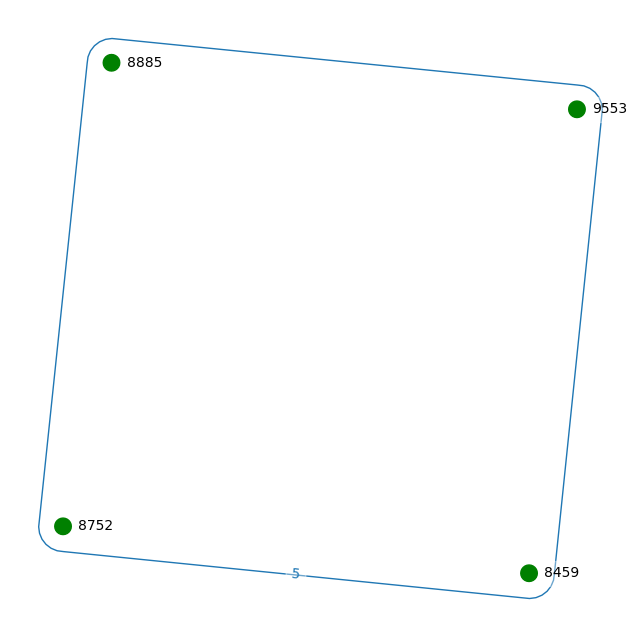

In [ ]:
import hypernetx as hnx
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig

# Sample dataset
edges = {
    0: [72, 165, 517],
    1: [875, 1024, 1742, 2059],
    2: [2252, 2429, 3622],
    3: [5036, 5080, 5088, 5703],
    4: [5873, 6723, 6752],
    5: [8459, 8752, 8885, 9553],
}

# Create a hypergraph from the dataset
H = hnx.Hypergraph(edges)

# Convert hypergraph to a bipartite graph
bipartite_graph = H.bipartite()

# Find connected components in the bipartite graph
components = list(nx.connected_components(bipartite_graph))

print(f"There are {len(components)} connected components.")

# Filter only node components (not edge components)
node_components = [comp for comp in components if any(node in H.nodes for node in comp)]

# Helper function to compute the Laplacian from the incidence matrix
def compute_laplacian(H):
    incidence_matrix = H.incidence_matrix().toarray()
    D_v = np.diag(np.sum(incidence_matrix, axis=1))  # Degree matrix for vertices
    D_e = np.diag(np.sum(incidence_matrix, axis=0))  # Degree matrix for edges
    L = D_v - np.dot(incidence_matrix, np.linalg.inv(D_e).dot(incidence_matrix.T))
    return L

# Perform clustering on each connected component
for i, component in enumerate(node_components):
    print(f"\nProcessing component {i + 1} with {len(component)} nodes.")
    sub_hypergraph = H.restrict_to_nodes(component)  # Restrict to the connected component

    # Adjust k to be less than the number of nodes in the component
    num_clusters = min(2, len(component) - 1)  # Set k appropriately

    if num_clusters > 1:
        # Compute Laplacian
        L = compute_laplacian(sub_hypergraph)  # Get the Laplacian matrix
        e, v = eig(L)  # Use dense eig for small graphs

        # Sort eigenvalues and corresponding eigenvectors
        sorted_indices = np.argsort(e)
        sorted_eigenvectors = v[:, sorted_indices]

        # Perform clustering based on eigenvectors
        clusters = {}
        for idx, node in enumerate(sub_hypergraph.nodes):
            cluster_id = np.argmax(sorted_eigenvectors[idx, :num_clusters])
            if cluster_id not in clusters:
                clusters[cluster_id] = []
            clusters[cluster_id].append(node)

        print(f"Clustering result for component {i + 1}:")
        print(clusters)

        # Visualize the clusters
        colors = ['r', 'g', 'b']
        node_colors = dict()
        for k, v in clusters.items():
            node_colors.update({vv: colors[k % len(colors)] for vv in v})

        hnx.draw(sub_hypergraph, nodes_kwargs={'color': node_colors})
        plt.show()
    else:
        print(f"Component {i + 1} is too small for clustering.")


# **Weighted Hypergraph Clustering Using TF-IDF Weights**

Weighted Hypergraph Clustering Result:
{0: [0, 2], 1: [1, 3]}


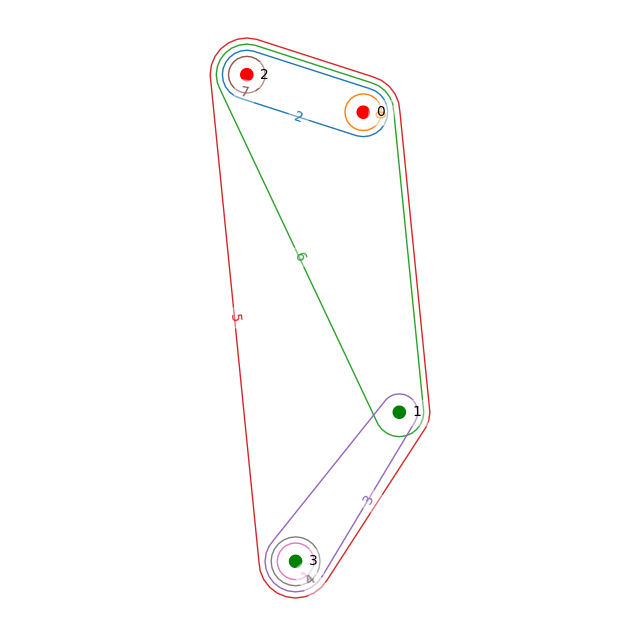

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix
import numpy as np
import hypernetx as hnx

# Sample dataset with vertex-hyperedge incidence relationships
documents = [
    "data analysis machine learning",
    "deep learning machine learning",
    "data science machine learning",
    "artificial intelligence deep learning",
]

# Convert documents to a TF-IDF matrix (this is just an example)
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(documents)

# Convert TF-IDF matrix to an incidence matrix
mat = coo_matrix(X_tfidf)

# Create a hypergraph from the incidence matrix
H_weighted = hnx.Hypergraph.from_incidence_matrix(mat)

# Perform weighted spectral clustering with 2 clusters
clusters_weighted = hnx.spec_clus(H_weighted, 2, weights=True)

# Display the resulting clusters
print("Weighted Hypergraph Clustering Result:")
print(clusters_weighted)

# Visualize clusters
colors = ['r', 'g']
node_colors = dict()
for k, v in clusters_weighted.items():
    node_colors.update({vv: colors[k] for vv in v})

hnx.draw(H_weighted, nodes_kwargs={'color': node_colors})
plt.show()


## **playing with youtube_top5000.txt dataset **

In [ ]:
import pandas as pd
import hypernetx as hnx

# Step 1: Read the file without specifying a delimiter
with open('youtube_top5000.txt', 'r') as file:
    data = file.readlines()

# Print the first few lines to inspect the structure
print("First 10 lines of the dataset:")
for line in data[:10]:  # Display the first 10 lines
    print(line.strip())

# Step 2: Process the data to create a list of edges
edges = []
for line in data:
    edges.append(line.strip().split())  # Adjust split method based on your inspection

# Step 3: Convert the list of edges to a DataFrame for hypernetx
# Here we assume each line represents a hyperedge
df = pd.DataFrame(edges)

# Step 4: Convert the DataFrame to a dictionary format suitable for hypernetx
hypergraph_edges = {i: df.iloc[i].dropna().tolist() for i in range(df.shape[0])}

# Create hypergraph
H = hnx.Hypergraph(hypergraph_edges)


First 10 lines of the dataset:
72	165	517	875	1024	1742	2059	2252	2429	3622	5036	5080	5088	5703	5873	6723	6752	8459	8752	8885	9553	10243	10763	13040	13841	15059	15231	15310	16100	19170	19573	20572	26797	27414	28080	28084	28755	40404	43824	48404	48423	48431	61005	83295	103527	108236	139888	156355	156534	175210	180201	181647	181664	181665	183004	203349	224411	279007	282577	287218	319813	458127	526519	645203
1	3	5	539	551	554	571	626	642	673	678	684	698	700	9314	24047	33897	36675	521325
519665	608725
157240	459129
590	29649
84114	382726
2	2014	3438	95969	132967	132972	132973	132978	132981	132982	132987	443577
1024	1291	1825	1864	1886	1970	1999	2287	2529	6444	6656	9532	11414	11897	16009	16010	18690	19989	20221	20328	20395	20426	20444	20509	20599	20796	20842	20889	21018	21021	21049	23130	24804	25746	28594	29293	30077	30191	36467	45639	49498	57083	63140	63616	64005	64042	65390	66862	72470	72550	73918	73921	78452	86337	87033	90490	91005	91307	91331	91778	91922	92031	92302	92719	93053	93149	93

In [ ]:
import pandas as pd
import hypernetx as hnx
import numpy as np
from scipy.sparse.csgraph import connected_components  # Import the connected_components function
from scipy.sparse import csr_matrix  # Import for sparse matrix handling

# Step 1: Read the file without specifying a delimiter
with open('youtube_top5000.txt', 'r') as file:
    data = file.readlines()

# Step 2: Process the data to create a list of edges
edges = []
for line in data:
    # Assuming space or comma as delimiter; adjust according to the actual file format
    edges.append(line.strip().split())  # Split each line into a list of vertices

# Step 3: Convert the list of edges to a DataFrame for hypernetx
# Here we assume each line represents a hyperedge
df = pd.DataFrame(edges)

# Step 4: Convert the DataFrame to a dictionary format suitable for hypernetx
hypergraph_edges = {i: df.iloc[i].dropna().tolist() for i in range(df.shape[0])}

# Create hypergraph
H = hnx.Hypergraph(hypergraph_edges)

In [ ]:
# Step 5: Check if the hypergraph is connected
if H.is_connected():
    print("The hypergraph is connected. Performing spectral clustering...")
    num_clusters = 3  # Define the number of clusters
    clusters = hnx.spec_clus(H, num_clusters)
    print("Clustering result:")
    print(clusters)
else:
    print("The hypergraph is not connected. Analyzing connected components...")

    # Convert the incidence matrix to a bipartite adjacency matrix
    incidence_matrix = H.incidence_matrix()
    adjacency_matrix = incidence_matrix @ incidence_matrix.T  # Get the adjacency matrix

    # Find connected components
    num_components, labels = connected_components(adjacency_matrix.toarray(), directed=False)

    print(f"There are {num_components} connected components.")

    # Process each component separately
    for i in range(num_components):
        # Extract nodes corresponding to this component
        component_nodes = np.where(labels == i)[0]
        component = [H.nodes[j] for j in component_nodes]  # Get the original node labels

        print(f"\nProcessing component {i + 1} with {len(component)} nodes.")
        sub_hypergraph = H.restrict_to_nodes(component)  # Restrict to the connected component

        # Perform spectral clustering on the sub-hypergraph
        if len(component) > 1:  # Only perform clustering if there are at least 2 nodes
            try:
                clusters = hnx.spec_clus(sub_hypergraph, 3)  # Number of clusters can be adjusted
                print(f"Clustering result for component {i + 1}:")
                print(clusters)
            except Exception as e:
                print(f"Error during clustering for component {i + 1}: {e}")
        else:
            print("Not enough nodes to perform clustering.")

The hypergraph is not connected. Analyzing connected components...


In [ ]:
# Step 5: Check if the hypergraph is connected
if H.is_connected():
    print("The hypergraph is connected. Performing spectral clustering...")
    num_clusters = 3  # Define the number of clusters
    clusters = hnx.spec_clus(H, num_clusters)
    print("Clustering result:")
    print(clusters)
else:
    print("The hypergraph is not connected. Analyzing connected components...")

    # Convert the incidence matrix to a bipartite adjacency matrix
    incidence_matrix = H.incidence_matrix()
    adjacency_matrix = incidence_matrix @ incidence_matrix.T  # Get the adjacency matrix

    # Find connected components
    num_components, labels = connected_components(adjacency_matrix.toarray(), directed=False)

    print(f"There are {num_components} connected components.")

    # Process each component separately
    for i in range(num_components):
        # Extract nodes corresponding to this component
        component_nodes = np.where(labels == i)[0]
        component = [H.nodes[j] for j in component_nodes]  # Get the original node labels

        print(f"\nProcessing component {i + 1} with {len(component)} nodes.")
        sub_hypergraph = H.restrict_to_nodes(component)  # Restrict to the connected component

        # Perform spectral clustering on the sub-hypergraph
        if len(component) > 1:  # Only perform clustering if there are at least 2 nodes
            try:
                clusters = hnx.spec_clus(sub_hypergraph, 3)  # Number of clusters can be adjusted
                print(f"Clustering result for component {i + 1}:")
                print(clusters)
            except Exception as e:
                print(f"Error during clustering for component {i + 1}: {e}")
        else:
            print("Not enough nodes to perform clustering.")

Not enough nodes to perform clustering.


# **using first 100 data**

In [ ]:
import pandas as pd
import hypernetx as hnx
import numpy as np
from scipy.sparse.csgraph import connected_components  # Import the connected_components function
from scipy.sparse import csr_matrix  # Import for sparse matrix handling

# Step 1: Read the first hundred lines from the file
with open('youtube_top5000.txt', 'r') as file:
    data = [file.readline().strip() for _ in range(100)]  # Read first 100 lines

# Step 2: Process the data to create a list of edges
edges = []
for line in data:
    edges.append(line.split())  # Split each line into a list of vertices

# Step 3: Convert the list of edges to a DataFrame for hypernetx
df = pd.DataFrame(edges)

# Step 4: Convert the DataFrame to a dictionary format suitable for hypernetx
hypergraph_edges = {i: df.iloc[i].dropna().tolist() for i in range(df.shape[0])}

# Create hypergraph
H = hnx.Hypergraph(hypergraph_edges)

# Step 5: Check if the hypergraph is connected
if H.is_connected():
    print("The hypergraph is connected. Performing spectral clustering...")
    num_clusters = 3  # Define the number of clusters
    clusters = hnx.spec_clus(H, num_clusters)
    print("Clustering result:")
    print(clusters)
else:
    print("The hypergraph is not connected. Analyzing connected components...")

    # Convert the incidence matrix to a bipartite adjacency matrix
    incidence_matrix = H.incidence_matrix()
    adjacency_matrix = incidence_matrix @ incidence_matrix.T  # Get the adjacency matrix

    # Find connected components
    num_components, labels = connected_components(adjacency_matrix.toarray(), directed=False)

    print(f"There are {num_components} connected components.")

    # Process each component separately
    for i in range(num_components):
        # Extract nodes corresponding to this component
        component_nodes = np.where(labels == i)[0]
        component = [H.nodes[j] for j in component_nodes]  # Get the original node labels

        print(f"\nProcessing component {i + 1} with {len(component)} nodes.")
        sub_hypergraph = H.restrict_to_nodes(component)  # Restrict to the connected component

        # Perform spectral clustering on the sub-hypergraph
        if len(component) > 1:  # Only perform clustering if there are at least 2 nodes
            try:
                clusters = hnx.spec_clus(sub_hypergraph, 3)  # Number of clusters can be adjusted
                print(f"Clustering result for component {i + 1}:")
                print(clusters)
            except Exception as e:
                print(f"Error during clustering for component {i + 1}: {e}")
        else:
            print("Not enough nodes to perform clustering.")


The hypergraph is not connected. Analyzing connected components...
There are 67 connected components.

Processing component 1 with 70 nodes.
Error during clustering for component 1: cannot infer dimensions from zero sized index arrays

Processing component 2 with 4656 nodes.
Error during clustering for component 2: cannot infer dimensions from zero sized index arrays

Processing component 3 with 2 nodes.
Error during clustering for component 3: cannot infer dimensions from zero sized index arrays

Processing component 4 with 2 nodes.
Error during clustering for component 4: cannot infer dimensions from zero sized index arrays

Processing component 5 with 2 nodes.
Error during clustering for component 5: cannot infer dimensions from zero sized index arrays

Processing component 6 with 2 nodes.
Error during clustering for component 6: cannot infer dimensions from zero sized index arrays

Processing component 7 with 2 nodes.
Error during clustering for component 7: cannot infer dimensions

# **Undirected**

In [1]:
!pip install networkx matplotlib

# **Using networkx**

The graph is connected.


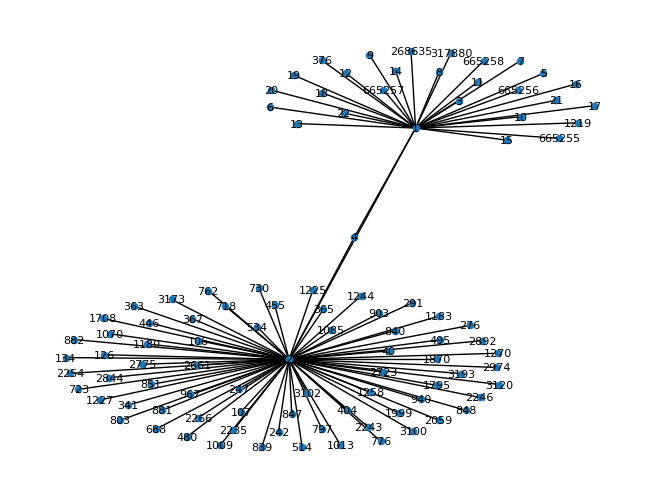

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Read the first hundred edges from the file
file_path = 'undirected.txt'
with open(file_path, 'r') as file:
    data = []
    for line in file:
        if not line.startswith("#"):  # Skip comment lines
            data.append(line.strip())
        if len(data) >= 100:  # Stop after 100 valid data lines
            break

# Step 2: Process the data into edges
edges = [tuple(map(int, line.split())) for line in data]  # Convert lines to tuples of integers

# Step 3: Create an undirected graph
G = nx.Graph()
G.add_edges_from(edges)

# Step 4: Analyze if the graph is connected
if nx.is_connected(G):
    print("The graph is connected.")
else:
    print("The graph is not connected.")
    num_components = nx.number_connected_components(G)
    print(f"There are {num_components} connected components.")

    # Display the largest connected component
    largest_component = max(nx.connected_components(G), key=len)
    print(f"Largest connected component has {len(largest_component)} nodes.")

# Step 5: Visualize the graph (for the first 100 edges)
# This graph is small enough to visualize, unlike the full dataset
nx.draw(G, with_labels=True, node_size=20, font_size=8)
plt.show()




---



---



# **File Reading**

In [7]:
def read_file(file_path, num_lines=100):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if not line.startswith("#"):  # Skip comment lines
                data.append(line.strip())
            if len(data) >= num_lines:  # Stop after required valid data lines
                break
    return data


# **Data Processing**

In [8]:
def process_data(data):
    edges = {i: list(map(int, line.split())) for i, line in enumerate(data)}
    return edges


# **Hypergraph Creation**

In [9]:
def create_hypergraph(edges):
    H = hnx.Hypergraph(edges)
    return H


# **Connected Components Detection**

In [11]:
import networkx as nx

def analyze_connected_components(H):
    # Project the hypergraph into a bipartite graph
    G = H.bipartite()
    G_proj = nx.projected_graph(G, H.nodes)

    # Find connected components
    connected_components = list(nx.connected_components(G_proj))

    if len(connected_components) == 1:
        print("The hypergraph is connected.")
    else:
        print("The hypergraph is not connected.")
        print(f"There are {len(connected_components)} connected components.")

        # Return the connected components for further analysis
        return connected_components


# **Visualization**

In [12]:
import matplotlib.pyplot as plt

def visualize_hypergraph(H):
    hnx.draw(H, with_edge_labels=True)
    plt.show()

# **Main Module**

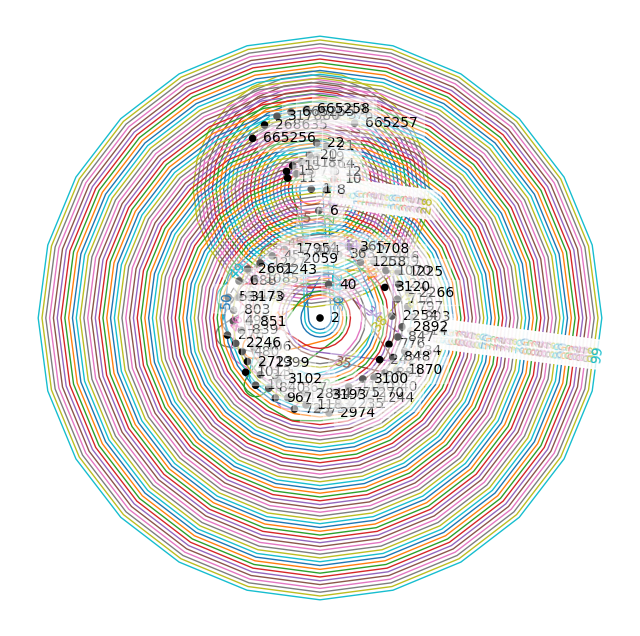

In [13]:
def main():
    # Step 1: File path (adjust this to point to your actual file)
    file_path = 'undirected.txt'

    # Step 2: Read the data
    data = read_file(file_path)

    # Step 3: Process the data into hyperedges
    edges = process_data(data)

    # Step 4: Create the hypergraph
    H = create_hypergraph(edges)

    # Step 5: Analyze the connected components
    connected_components = analyze_connected_components(H)

    # Step 6: Visualize the hypergraph
    visualize_hypergraph(H)
main()


# **Only first 50 data**

The hypergraph is connected.


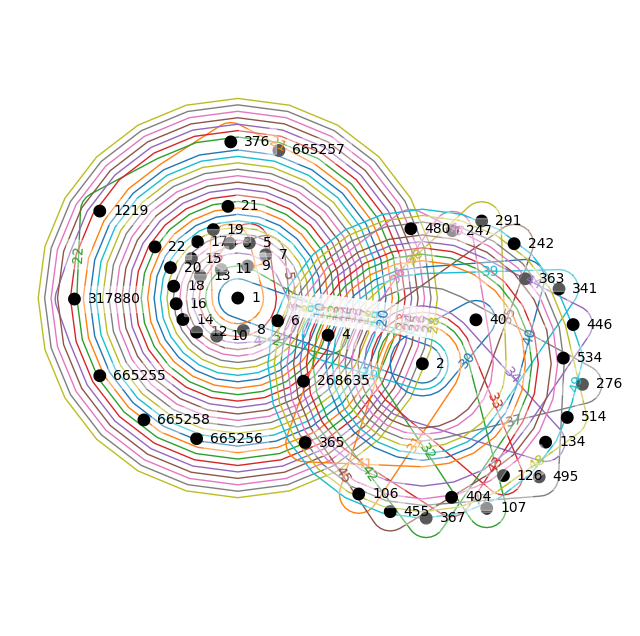

In [14]:
def main():
    # Step 1: File path (adjust this to point to your actual file)
    file_path = 'undirected.txt'

    # Step 2: Read the data
    data = read_file(file_path, num_lines=50)  # Read only the first 50 lines

    # Step 3: Process the data into hyperedges
    edges = process_data(data)

    # Step 4: Create the hypergraph
    H = create_hypergraph(edges)

    # Step 5: Analyze the connected components
    connected_components = analyze_connected_components(H)

    # Step 6: Visualize the hypergraph
    visualize_hypergraph(H)

# Call the main function to execute the process
main()


# **first 10 data**

The hypergraph is connected.


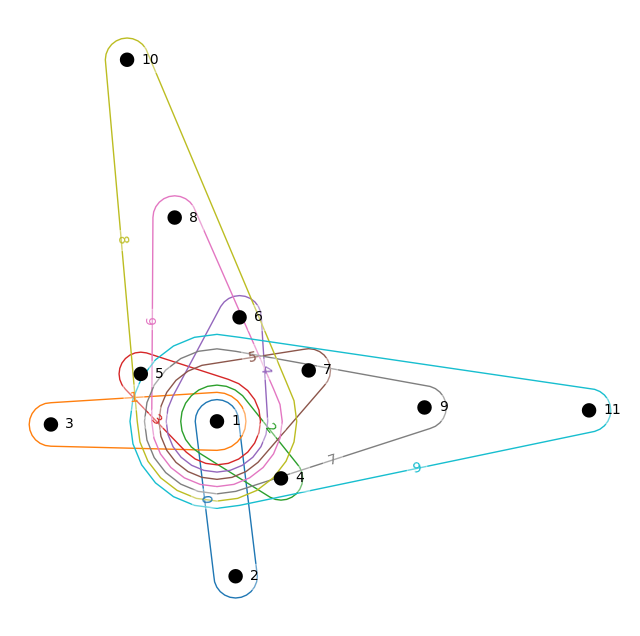

In [18]:
def main():
    # Step 1: File path (adjust this to point to your actual file)
    file_path = 'undirected.txt'

    # Step 2: Read the data
    data = read_file(file_path, num_lines=10)  # Read only the first 50 lines

    # Step 3: Process the data into hyperedges
    edges = process_data(data)

    # Step 4: Create the hypergraph
    H = create_hypergraph(edges)

    # Step 5: Analyze the connected components
    connected_components = analyze_connected_components(H)

    # Step 6: Visualize the hypergraph
    visualize_hypergraph(H)

# Call the main function to execute the process
main()




---



---



# **Directed.txt**

In [32]:
pip install networkx

In [46]:
import hypernetx as hnx
import networkx as nx

def read_file(file_path, num_lines=50):
    """Read the first `num_lines` from the directed graph file."""
    with open(file_path, 'r') as file:
        # Skip header lines and read specified number of lines
        for _ in range(2):  # Skip the first two lines of metadata
            next(file)
        data = [file.readline().strip().split() for _ in range(num_lines)]
    return data


In [47]:
def process_data(data):
    """Convert the list of lines into a list of edges suitable for hypernetx."""
    edges = []
    for line in data:
        if line:  # Ensure line is not empty
            # Filter out any empty strings and convert to integers
            edge = [int(x) for x in line if x.strip().isdigit()]
            if edge:  # Only add non-empty edges
                edges.append(edge)
    return edges


In [48]:
import hypernetx as hnx

def create_hypergraph(edges):
    """Create a hypergraph from the edges dictionary."""
    return hnx.Hypergraph(edges)


In [49]:
def analyze_connected_components(H):
    """Analyze connected components in the hypergraph."""
    # Manually create an undirected graph from the hypergraph edges
    G = nx.Graph()

    # Add edges to the graph
    for edge in H.edges:  # H.edges should be a list of hyperedges
        if isinstance(edge, (list, set)):  # Check if edge is a list or set
            edge_nodes = list(edge)  # Get the actual nodes in the edge
            G.add_nodes_from(edge_nodes)  # Add all nodes in the edge
            # Create edges between all pairs of nodes in the edge
            G.add_edges_from([(edge_nodes[i], edge_nodes[j]) for i in range(len(edge_nodes)) for j in range(i + 1, len(edge_nodes))])
        else:
            print(f"Unexpected edge type: {type(edge)}. Edge content: {edge}")  # Debugging line

    # Find connected components using networkx
    components = list(nx.connected_components(G))
    print(f"There are {len(components)} connected components.")
    return components



In [50]:
def visualize_hypergraph(H):
    """Visualize the hypergraph."""
    hnx.draw(H)

Edges: [[519665, 608725], [282492, 406981], [234132, 234134], [157240, 459129], [114418, 114459], [58180, 335490], [28200, 282586], [27182, 106235], [25803, 90518], [24051, 37101]]
Unexpected edge type: <class 'numpy.int64'>. Edge content: 0
Unexpected edge type: <class 'numpy.int64'>. Edge content: 1
Unexpected edge type: <class 'numpy.int64'>. Edge content: 2
Unexpected edge type: <class 'numpy.int64'>. Edge content: 3
Unexpected edge type: <class 'numpy.int64'>. Edge content: 4
Unexpected edge type: <class 'numpy.int64'>. Edge content: 5
Unexpected edge type: <class 'numpy.int64'>. Edge content: 6
Unexpected edge type: <class 'numpy.int64'>. Edge content: 7
Unexpected edge type: <class 'numpy.int64'>. Edge content: 8
Unexpected edge type: <class 'numpy.int64'>. Edge content: 9
There are 0 connected components.


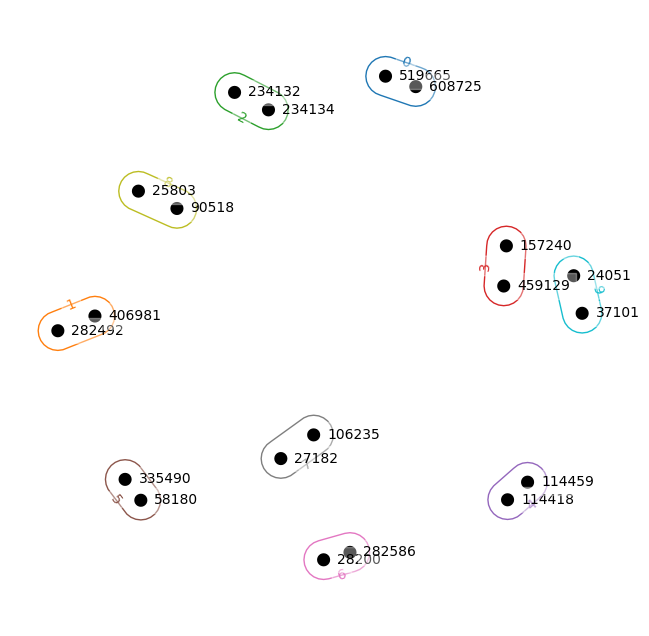

In [52]:
def main():
    # Step 1: File path (adjust this to point to your actual file)
    file_path = 'directed.txt'

    # Step 2: Read the data
    data = read_file(file_path, num_lines=10)  # Read only the first 50 lines

    # Step 3: Process the data into hyperedges
    edges = process_data(data)
    print("Edges:", edges)  # Add this line to inspect the edges format

    # Step 4: Create the hypergraph
    H = create_hypergraph(edges)

    # Step 5: Analyze the connected components
    components = analyze_connected_components(H)

    # Step 6: Visualize the hypergraph (optional)
    visualize_hypergraph(H)

# Call the main function to execute the process
main()

Edges: [[519665, 608725], [282492, 406981], [234132, 234134], [157240, 459129], [114418, 114459], [58180, 335490], [28200, 282586], [27182, 106235], [25803, 90518], [24051, 37101], [19715, 51027], [11645, 27093], [10191, 10992], [4221, 128864], [1, 5, 571, 626, 678], [15487, 101063], [6253, 19271], [281546, 395995], [137116, 260434], [590, 29649], [2, 3377, 3387, 3394, 3396, 131565], [84114, 382726], [2, 2014, 3438, 95969, 132967, 132972, 132973, 132978, 132981, 132982, 132987, 443577], [743, 59381], [1024, 1291, 1825, 1864, 1886, 1970, 1999, 2287, 2529, 6444, 6656, 9532, 11414, 11897, 16009, 16010, 18690, 19989, 20221, 20328, 20395, 20426, 20444, 20509, 20599, 20796, 20842, 20889, 21018, 21021, 21049, 23130, 24804, 25746, 28594, 29293, 30077, 30191, 36467, 45639, 49498, 57083, 63140, 63616, 64005, 64042, 65390, 66862, 72470, 72550, 73918, 73921, 78452, 86337, 87033, 90490, 91005, 91307, 91331, 91778, 91922, 92031, 92302, 92719, 93053, 93149, 93150, 93167, 93627, 93849, 94042, 95497, 9

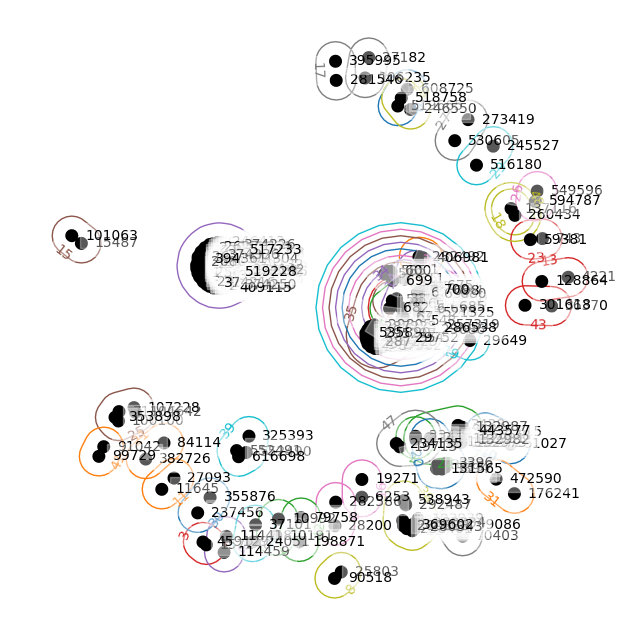

In [45]:
import hypernetx as hnx
import networkx as nx

def read_file(file_path, num_lines=50):
    """Read the first `num_lines` from the directed graph file."""
    with open(file_path, 'r') as file:
        # Skip header lines and read specified number of lines
        for _ in range(2):  # Skip the first two lines of metadata
            next(file)
        data = [file.readline().strip().split() for _ in range(num_lines)]
    return data

def process_data(data):
    """Convert the list of lines into a list of edges suitable for hypernetx."""
    edges = []
    for line in data:
        if line:  # Ensure line is not empty
            # Filter out any empty strings and convert to integers
            edge = [int(x) for x in line if x.strip().isdigit()]
            if edge:  # Only add non-empty edges
                edges.append(edge)
    return edges

def create_hypergraph(edges):
    """Create a hypergraph from the edges list."""
    print("Edges processed for hypergraph:", edges)  # Debugging line
    return hnx.Hypergraph(edges)

def analyze_connected_components(H):
    """Analyze connected components in the hypergraph."""
    # Manually create an undirected graph from the hypergraph edges
    G = nx.Graph()

    # Add edges to the graph
    for edge in H.edges:  # H.edges should be a list of hyperedges
        if isinstance(edge, (list, set)):  # Check if edge is a list or set
            edge_nodes = list(edge)  # Get the actual nodes in the edge
            G.add_nodes_from(edge_nodes)  # Add all nodes in the edge
            # Create edges between all pairs of nodes in the edge
            G.add_edges_from([(edge_nodes[i], edge_nodes[j]) for i in range(len(edge_nodes)) for j in range(i + 1, len(edge_nodes))])
        else:
            print(f"Unexpected edge type: {type(edge)}. Edge content: {edge}")  # Debugging line

    # Find connected components using networkx
    components = list(nx.connected_components(G))
    print(f"There are {len(components)} connected components.")
    return components

def visualize_hypergraph(H):
    """Visualize the hypergraph."""
    hnx.draw(H)

def main():
    # Step 1: File path (adjust this to point to your actual file)
    file_path = 'directed.txt'

    # Step 2: Read the data
    data = read_file(file_path, num_lines=50)  # Read only the first 50 lines

    # Step 3: Process the data into hyperedges
    edges = process_data(data)
    print("Edges:", edges)  # Add this line to inspect the edges format

    # Step 4: Create the hypergraph
    H = create_hypergraph(edges)

    # Step 5: Analyze the connected components
    components = analyze_connected_components(H)

    # Step 6: Visualize the hypergraph (optional)
    visualize_hypergraph(H)

# Call the main function to execute the process
main()




---



---



In [78]:
import hypernetx as hnx
import networkx as nx
import matplotlib.pyplot as plt

def process_hypergraph_data(filename):
    """Read the hypergraph data from a file and create edges."""
    edges = []
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading and trailing whitespace
            if not line or line.startswith("#"):  # Skip empty lines and comment lines
                continue
            parts = list(map(int, line.split()))  # Convert all parts to integers
            connected_edges = parts  # Treat entire line as a hyperedge
            edges.append(connected_edges)  # Add the hyperedge to the list
    return edges

def create_hypergraph(edges):
    """Create a hypergraph from processed edges."""
    return hnx.Hypergraph(edges)


In [79]:
def analyze_connected_components(H):
    """Analyze connected components in the hypergraph."""
    print("Type of H:", type(H))
    print("H.edges:", H.edges)  # This shows the view but not its content directly.

    # Convert hypergraph to directed graph
    G = nx.DiGraph()

    # Iterate over the hyperedges in the hypergraph
    for edge in H.edges:  # H.edges is an iterable of edges
        # Check if edge is iterable and contains nodes
        if isinstance(edge, (list, set, tuple)):
            for u in edge:
                for v in edge:
                    if u != v:  # Avoid self-loops
                        G.add_edge(u, v)

    # Find strongly connected components using NetworkX
    components = list(nx.strongly_connected_components(G))
    print(f"There are {len(components)} strongly connected components.")

    return components, G  # Return components and the graph for visualization


In [80]:
def visualize_graph(G, components):
    """Visualize the directed graph and its strongly connected components."""
    if G is None:
        print("No graph to visualize.")
        return

    pos = nx.spring_layout(G)  # Positioning the nodes using spring layout

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', arrows=True)

    # Highlight the strongly connected components
    for idx, component in enumerate(components):
        subgraph = G.subgraph(component)
        nx.draw(subgraph, pos, with_labels=True, node_color=f'C{idx}', node_size=700, font_size=12)

    plt.title("Directed Graph with Strongly Connected Components")
    plt.show()

In [81]:

def main():
    # Filename of the directed graph data
    filename = 'directed.txt'

    # Process data into hyperedges
    edges = process_hypergraph_data(filename)
    print("Edges:", edges)  # Inspect edges format

    # Create hypergraph
    H = create_hypergraph(edges)

    # Analyze connected components
    components, G = analyze_connected_components(H)

    # Check if components were found before visualizing
    if components:
        visualize_graph(G, components)
    else:
        print("No components found. Visualization skipped.")

if __name__ == "__main__":
    main()


Edges: [[72, 165, 517, 875, 1024, 1742, 2059, 2252, 2429, 3622, 5036, 5080, 5088, 5703, 5873, 6723, 6752, 8459, 8752, 8885, 9553, 10243, 10763, 13040, 13841, 15059, 15231, 15310, 16100, 19170, 19573, 20572, 26797, 27414, 28080, 28084, 28755, 40404, 43824, 48404, 48423, 48431, 61005, 83295, 103527, 108236, 139888, 156355, 156534, 175210, 180201, 181647, 181664, 181665, 183004, 203349, 224411, 279007, 282577, 287218, 319813, 458127, 526519, 645203], [1, 3, 5, 539, 551, 554, 571, 626, 642, 673, 678, 684, 698, 700, 9314, 24047, 33897, 36675, 521325], [519665, 608725], [282492, 406981], [234132, 234134], [157240, 459129], [114418, 114459], [58180, 335490], [28200, 282586], [27182, 106235], [25803, 90518], [24051, 37101], [19715, 51027], [11645, 27093], [10191, 10992], [4221, 128864], [1, 5, 571, 626, 678], [15487, 101063], [6253, 19271], [281546, 395995], [137116, 260434], [590, 29649], [2, 3377, 3387, 3394, 3396, 131565], [84114, 382726], [2, 2014, 3438, 95969, 132967, 132972, 132973, 1329